# Deep Dream 

`Deep Dream`은 2015년, 구글에서 발표된, CNN을 이용한 Image modification 기술이다. 아래의 그림과 같이 마치 꿈 속에서의 그림 처럼 보이고, 사진에서 벌레나, 개, 새 등의 사물이 추상적으로 표현된다는 특징 덕분에, 당시 인터넷에 크게 유행 하기도 했다. 

`Deep Dream`은 기존의 CNN의 필터를 시각화하는 작업과 맥을 같이 한다. `Deep Dream`은 아래와 같은 특징을 가지고 있다. 

  1. 전역적 경사 상승 법(Gradient Ascent)
    - CNN 필터를 시각화 하기 위해서, Convolutional Layer의 필터의 활성화를 최대화 하기 위해, Gradient Ascent 방법을 사용했다. `Deep Dream` 에서는 특정 레이어에만 이를 적용하는 것이 아니라, 모든 레이어에 대해 적용하여, 많은 특징들을 한번에 표현하려 했다. 
  2. 실제 이미지를 입력
    - 빈 이미지나, 잡음이 심한 이미지로 부터 시각화 하는 것이 아니라, 실제 이미지로 부터 시각화 하기 때문에, 원래의 이미지의 시각적 패턴을 잘 가지게 되었다. 
  3. 여러 크기의 이미지를 처리 
    - 좀 더 나은 결과를 위해, 여러 크기의 이미지를 처리 하였다. 
 

In [1]:
# Load Pretrained model

from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf


# 이 훈련된 가중치를 사용하기 때문에, 학습관련 연산자를 비활성화 시킨다.
K.set_learning_phase(0) 

model = inception_v3.InceptionV3(include_top=False, weights='imagenet')

# include_top : 마지막 Fully Connectted layer를 포함하여 불러올것인가를 설정하는 것이다.

Using TensorFlow backend.


In [2]:
# Compute LOSS ; 경사 상승을 하면서 목표로 하는 정량적인 값 - 모든 레이어의 모든 필터를 동시에 최대화 할 것이다.

# loss에 반영할 레이어 와 그에 해당하는 가중치 
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)

for layer_name in layer_contributions:
    
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    x = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    
    loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [52]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]

fetch_loss_and_grads = K.Function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])  ## outputs 
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

#### -> 그냥 이렇게, loss_value, grad_values = fetch_loss_and_grads([dream])

def gradient_ascent(x, iterations, step, max_loss=None):

    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
            print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return sp.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    sp.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    
    return img

def deprocess_image(x):
    
    x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x -= x.mean()
    x /= x.std()
    x *= 255 
    x = np.clip(x, 0, 255)
    return x

In [56]:
#### Parameters ####
K.get_session().run(tf.initialize_all_variables())
step = 0.001
num_octave = 3
octave_scale = 1.4
iterations = 10
max_loss = 10.

from skimage import data

img = data.astronaut()
img = img.astype('float32')
img = np.array([img]) # 데이터 셋에서의 이미지의 쉐입과 맞추어주는 것 

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1] # 스케일 리스트 

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) # starting from smallest image

for shape in successive_shapes:
    
    print('Processing image shape', shape)
    
    img = resize_img(img, shape)
    
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)

    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)

    same_size_original = resize_img(original_img, shape)
    
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    
    shrunk_original_img = resize_img(original_img, shape)

# save_img(img.astype("uint8"), fname='final_dream.png')

Processing image shape (261, 261)
Processing image shape (365, 365)
Processing image shape (512, 512)


In [57]:
img

array([[[[154., 147., 151.],
         [109., 103., 124.],
         [ 63.,  58., 102.],
         ...,
         [127., 120., 115.],
         [120., 117., 106.],
         [125., 119., 110.]],

        [[177., 171., 171.],
         [144., 141., 143.],
         [113., 114., 124.],
         ...,
         [127., 118., 112.],
         [124., 115., 108.],
         [121., 116., 105.]],

        [[201., 194., 193.],
         [182., 178., 175.],
         [168., 165., 164.],
         ...,
         [128., 120., 117.],
         [126., 116., 112.],
         [124., 114., 109.]],

        ...,

        [[186., 170., 176.],
         [186., 170., 177.],
         [183., 168., 170.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   1.],
         [  0.,   0.,   0.]],

        [[183., 169., 170.],
         [182., 167., 171.],
         [185., 164., 176.],
         ...,
         [  0.,   0.,   1.],
         [  1.,   1.,   1.],
         [  0.,   0.,   0.]],

        [[184., 167., 172.],
       

In [54]:
deprocess_image(img)

array([[[123.66967  , 101.69677  , 114.25243  ],
        [  0.       ,   0.       ,  29.49951  ],
        [  0.       ,   0.       ,   0.       ],
        ...,
        [ 38.9165   ,  16.943602 ,   1.2485352],
        [ 16.943602 ,   7.5263667,   0.       ],
        [ 32.63867  ,  13.804442 ,   0.       ]],

       [[195.86646  , 177.03246  , 177.03246  ],
        [ 92.27954  ,  82.86254  ,  89.14037  ],
        [  0.       ,   0.       ,  29.49951  ],
        ...,
        [ 38.9165   ,  10.665527 ,   0.       ],
        [ 29.49951  ,   1.2485352,   0.       ],
        [ 20.082762 ,   4.387695 ,   0.       ]],

       [[255.       , 249.22948  , 246.09056  ],
        [211.56151  , 199.0056   , 189.58861  ],
        [167.6157   , 158.19847  , 155.05956  ],
        ...,
        [ 42.05566  ,  16.943602 ,   7.5263667],
        [ 35.77734  ,   4.387695 ,   0.       ],
        [ 29.49951  ,   0.       ,   0.       ]],

       ...,

       [[224.11742  , 173.89355  , 192.72728  ],
        [22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


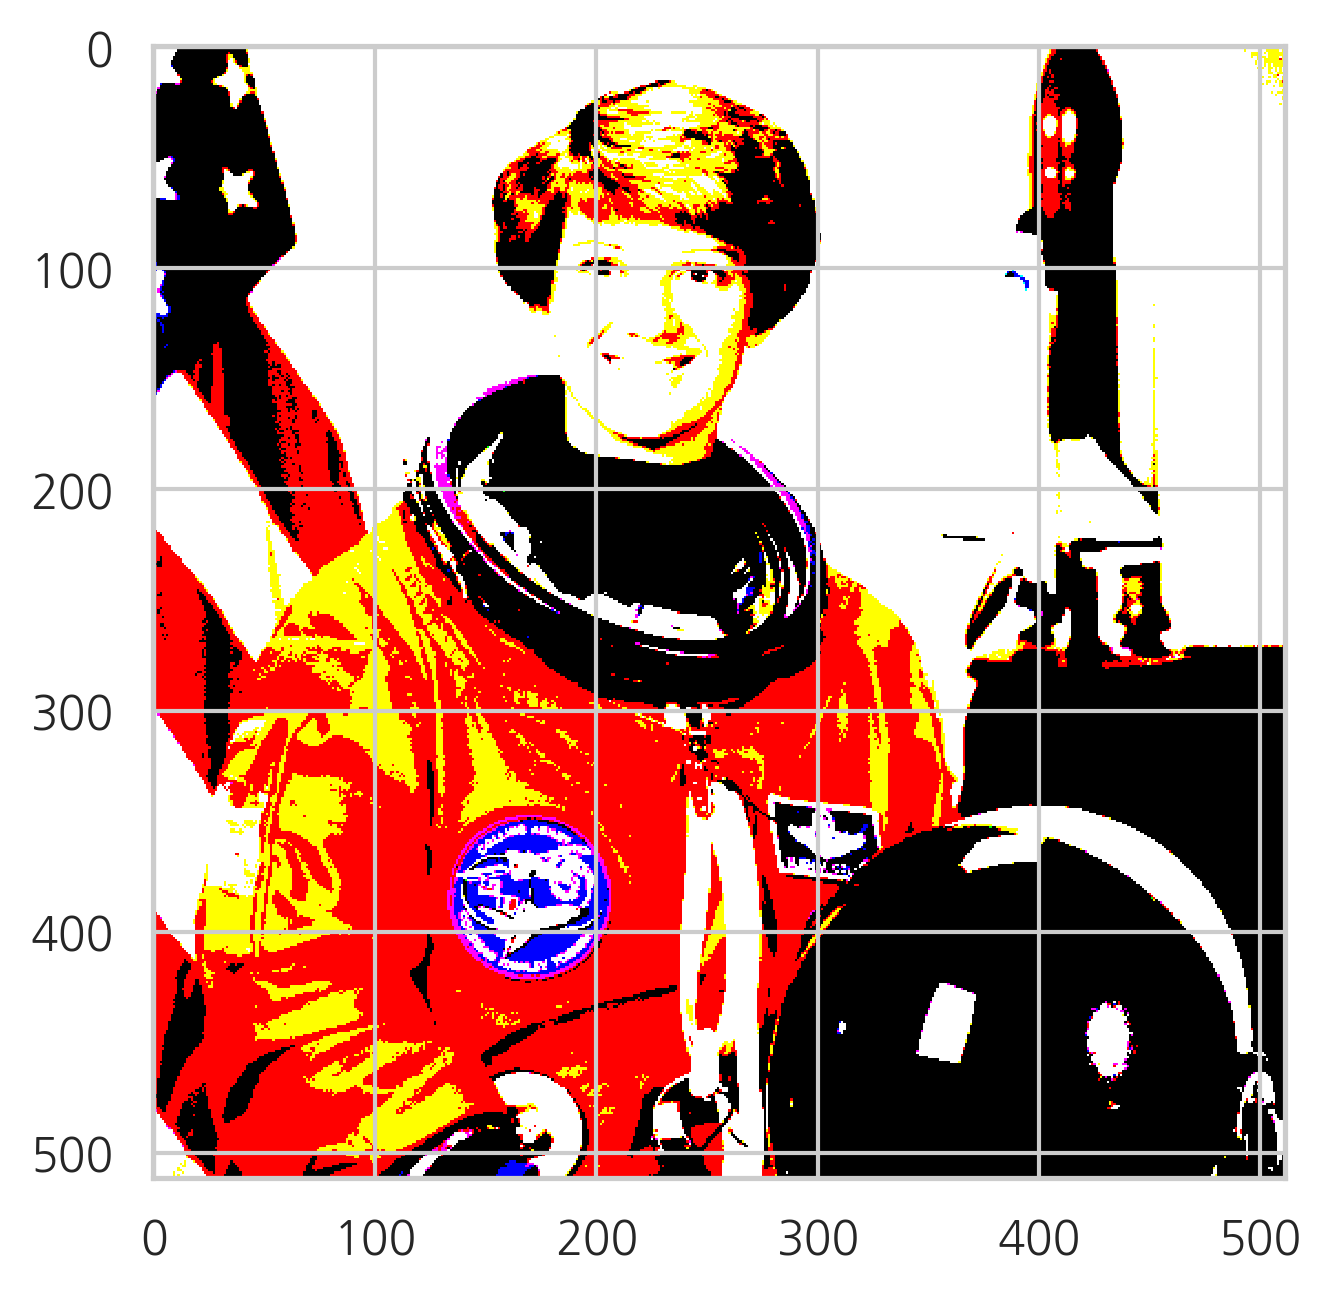

In [60]:
plt.imshow(deprocess_image(img))